# Advanced Learning Algorithms

In [3]:
import os
import numpy as np
import pandas as pd

import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import copy

torch.set_float32_matmul_precision('medium')

### Activation functions

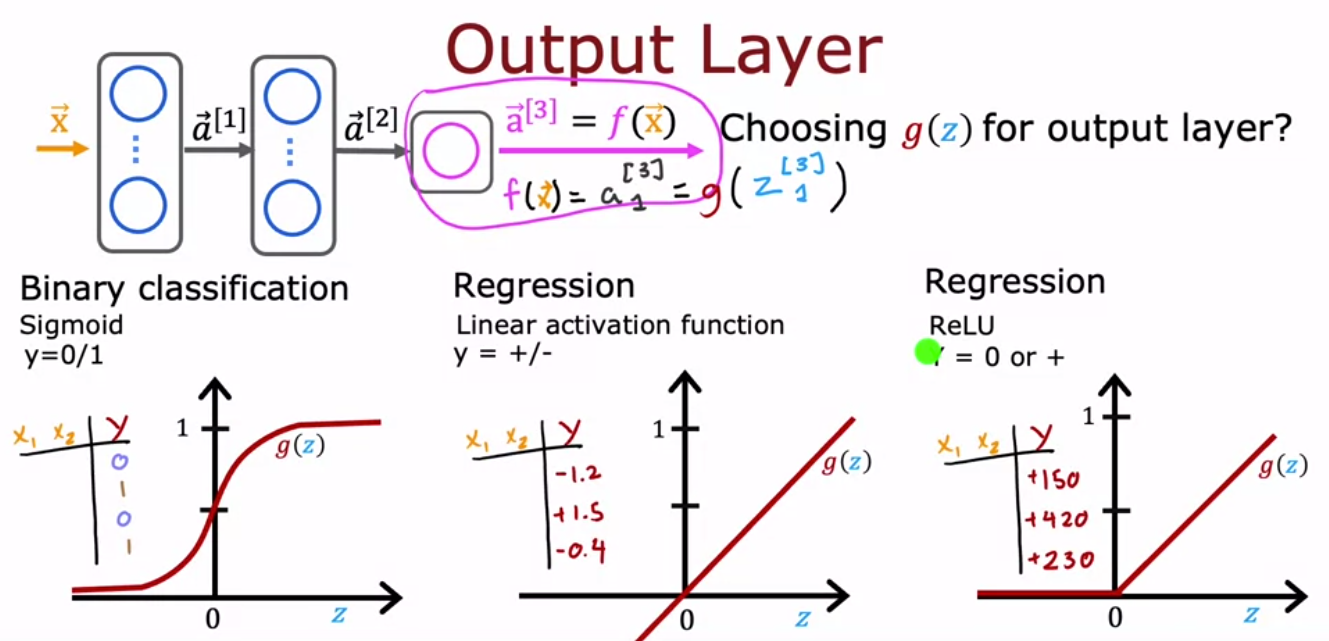

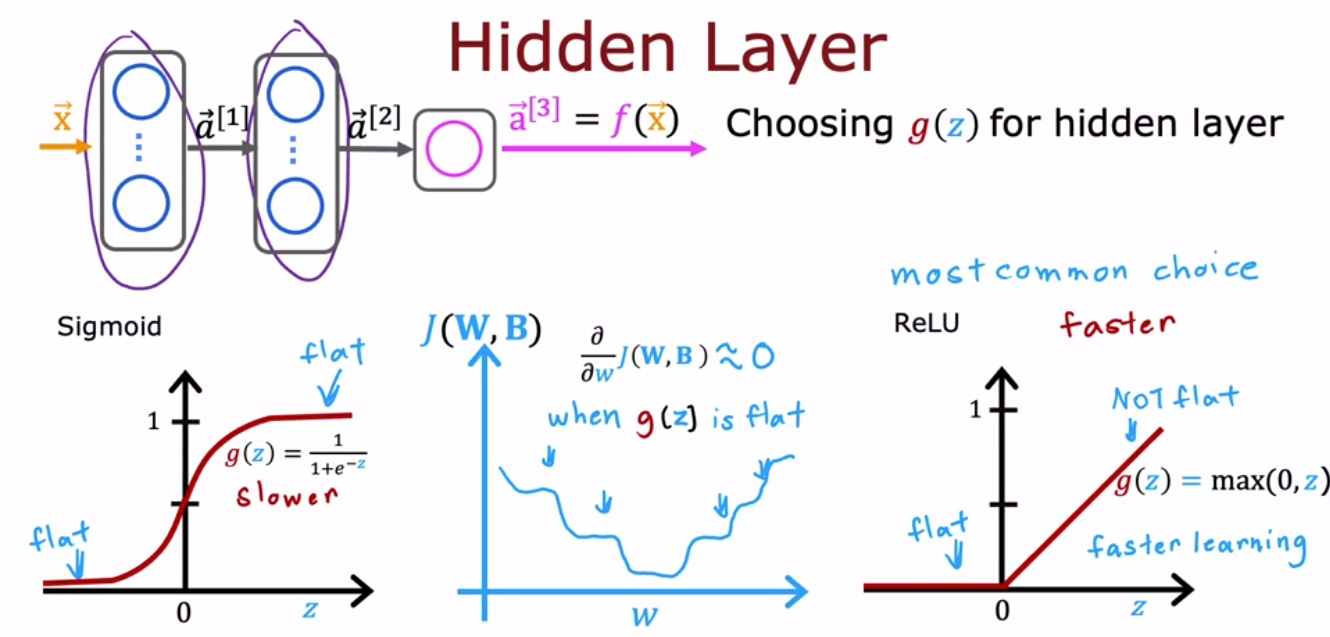

ReLU is faster to compute and leads to faster learning

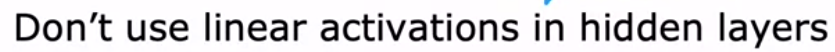

### Multiclass classification

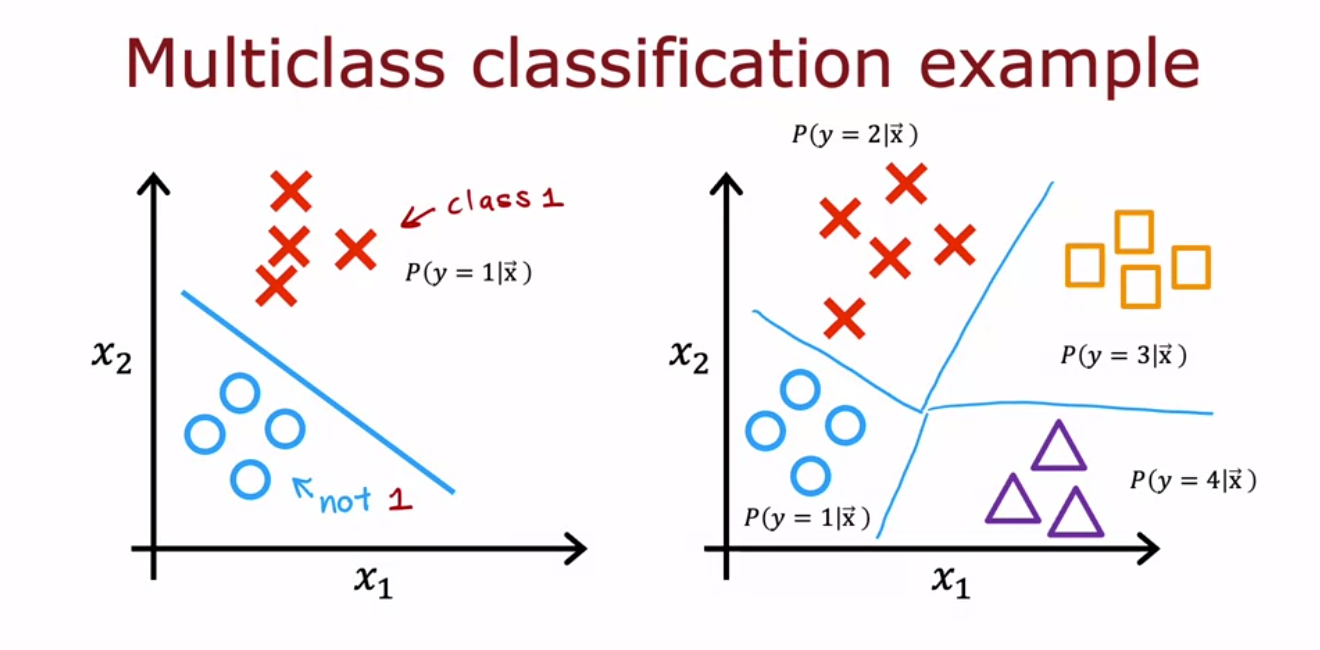

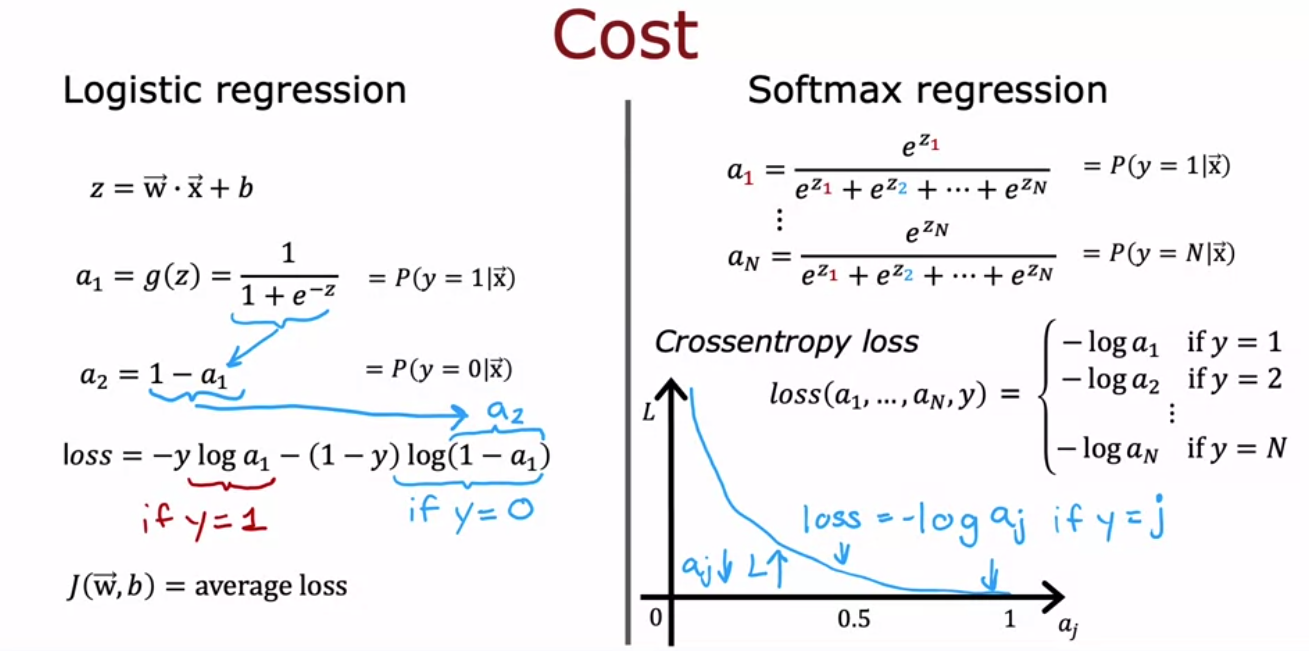

### Multiclass classification make_blobs example

In [12]:
from sklearn.datasets import make_blobs
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import copy

torch.set_float32_matmul_precision('medium')

# make 4-class dataset for classification
classes = 4
m = 100
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std,random_state=30)

<Axes: xlabel='X1', ylabel='X2'>

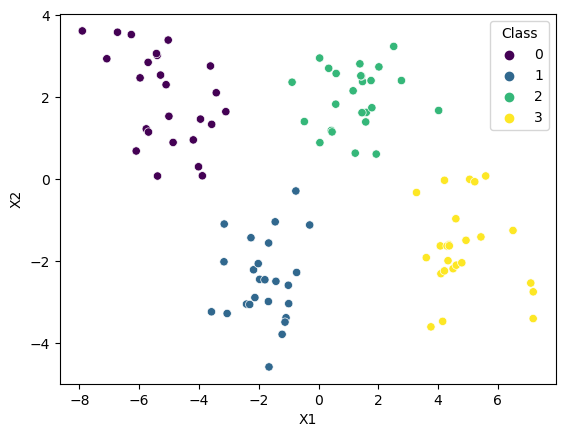

In [11]:
import seaborn as sns

# Create a dataframe from X_train and y_train
df_train = pd.DataFrame({'X1': X_train[:, 0], 'X2': X_train[:, 1], 'Class': y_train})

# Plot the data
sns.scatterplot(data=df_train, x='X1', y='X2', hue='Class', palette='viridis')

In [7]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show how classes are represented
print(f"class representation {y_train[:10]}")
# show shapes of our dataset
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2 3]
class representation [3 3 3 0 3 3 3 3 2 0]
shape of X_train: (100, 2), shape of y_train: (100,)


#### Lightning

In [87]:
class NNMultiClassClassifier(LightningModule):
    def __init__(self, inplace=False):
        super(NNMultiClassClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(inplace=inplace),
            nn.Linear(2, 4),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        # logits is the raw output of the last layer, before it's passed to softmax
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        return optimizer

In [88]:
model_lightning = NNMultiClassClassifier()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_tensor = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=12)

trainer = Trainer(max_epochs=200, log_every_n_steps=1)
trainer.fit(model_lightning, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | model   | Sequential | 18    
---------------------------------------
18        Trainable params
0         Non-trainable params
18        Total params
0.000     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 12.73it/s, v_num=8]


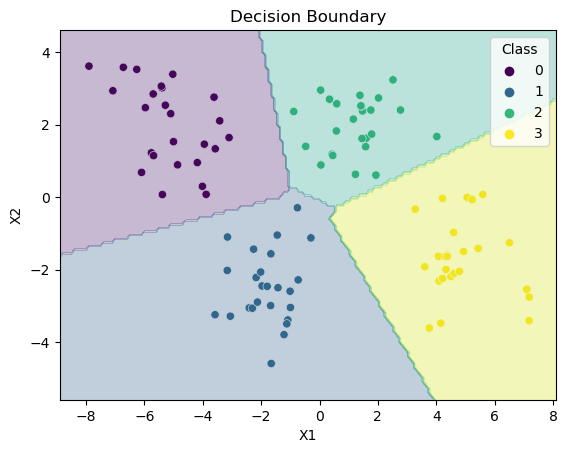

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a meshgrid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Flatten and predict the class labels for the meshgrid points
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_labels = model_lightning(torch.tensor(meshgrid_points, dtype=torch.float32)).argmax(dim=1)
meshgrid_labels = meshgrid_labels.reshape(xx.shape)

# Create a scatter plot of the training data points
sns.scatterplot(data=df_train, x='X1', y='X2', hue='Class', palette='viridis')

# Overlay the decision boundary
plt.contourf(xx, yy, meshgrid_labels, alpha=0.3, cmap='viridis')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary')
plt.show()

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# Create a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid = np.c_[xx.ravel(), yy.ravel()]

grid_torch = torch.from_numpy(grid).float()

output = torch.nn.functional.relu(model_lightning.model[0](grid_torch))

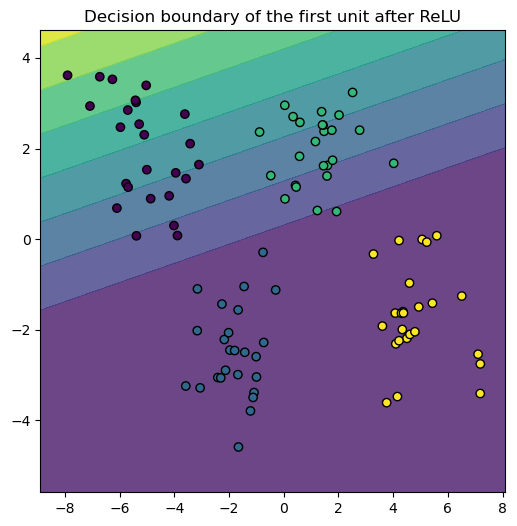

In [115]:
z1 = output[:, 0].detach().numpy()
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, z1.reshape(xx.shape), alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k')
plt.title('Decision boundary of the first unit after ReLU')
plt.show()

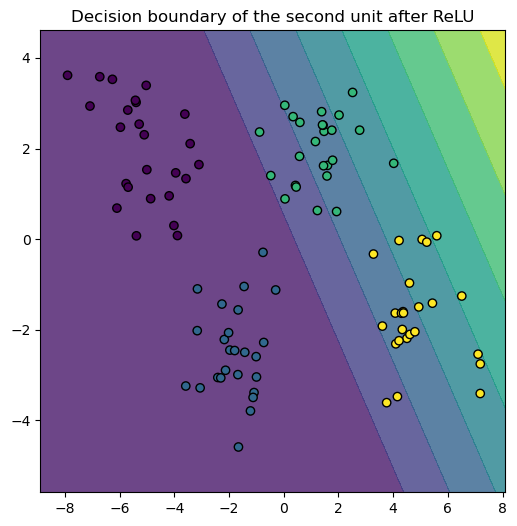

In [120]:
# Extract the output of the first unit
z2 = output[:, 1].detach().numpy()
# Plot the output of the first unit
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, z2.reshape(xx.shape), alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k')
plt.title('Decision boundary of the second unit after ReLU')
plt.show()